## Short Term Wind Climate 
**5. Filter data: (report page 30 - 33)**
- Outliers in wind speed and direction 
- Datagaps: Done in 'Overwiev'

**6. Interpolate:**
- Interpolate to the  one height of interest (= 150 meters for current turbine)

**7. Compare the both met masts:**
- Scatterplot: windspeed 150 m height mast one against windspeed 150m height mast 2 
- Same with the wind direction 
- Correlate with r^2 - linear correlation for both

**8. Short Term Wind Analysis**
- Mean, stdv of monthly and annual ws 
- Wind roses 
- Select parameters for Weibull model 
- Plot Weibull model 
- Diurnal profile of wind speed (blue) and wind direction (red) at HKW at 100 m MSL
- Monthly profile of the wind speed 
- Power curve of such a turbine
- Annual production of one turbine
- Annual production of wind farm


### Import Libraries and Load Data 

In [1]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import xarray as xr
import pandas as pd
import os
import netCDF4 as nc
from netCDF4 import Dataset
import numpy as np
from scipy.stats import linregress


In [2]:
# Data Paths
bouy6_path = 'data/measurements/2023-11-06_Buoy6_BSH_N-9.nc'
bouy2_path = 'data/measurements/2023-11-09_Buoy2_BSH_N-9.nc'
era5_path = 'data/reanalysis/'
turbines_existing_path = 'data/turbine-info/coordinates/existing/'
turbines_planned_future_path = 'data/turbine-info/coordinates/planned_future/'
turbines_planned_in_operation_before_2030_path = 'data/turbine-info/coordinates/planned_in_operation_before_2030/'
turbines_planned_netherlands_path = 'data/turbine-info/coordinates/planned_netherlands/'
turbines_area_of_interest_path = 'data/turbine-info/coordinates/area_of_interest/'
shapefiles_DEU_path = 'data/shapefiles/DEU/*'
shapefiles_DNK_path = 'data/shapefiles/DNK/*'
shapefiles_NLD_path = 'data/shapefiles/NLD/*'
turbine_power_curves_path = 'data/turbine-info/power_curves/'

From 'Overview' we decided to work with: buoy_6_measured and buoy_2_correlated_with_6 bcs. buoy 2 had a lot of data gaps (not a complete year measured)

In [3]:
#Load the datafiles in xr and netcdf 

xrbuoy6 = xr.open_dataset(bouy6_path)
xrbuoy2 = xr.open_dataset(bouy2_path)

buoy2_file = Dataset(bouy2_path)
buoy6_file = Dataset(bouy6_path)

In [4]:
xrbuoy2

<xarray.Dataset> Size: 541kB
Dimensions:    (longitude: 1, latitude: 1, time: 67680, height: 6)
Coordinates:
  * longitude  (longitude) float32 4B 5.792
  * latitude   (latitude) float32 4B 54.5
  * time       (time) datetime64[ns] 541kB 2022-03-03 ... 2023-06-15T23:49:59...
  * height     (height) int32 24B 14 41 94 140 200 250
Data variables:
    *empty*
Attributes:
    long_name:    Data measured by the sensors mounted on the Fraunhofer IWES...
    description:  BSH N-9 Fraunhofer IWES WLBZ_2 data from the period 2022-03...
    disclaimer:   The use of the data is in the sole responsibility of the user.

In [5]:
xrbuoy6

<xarray.Dataset> Size: 458kB
Dimensions:    (longitude: 1, latitude: 1, time: 57196, height: 6)
Coordinates:
  * longitude  (longitude) float32 4B 5.521
  * latitude   (latitude) float32 4B 54.4
  * time       (time) datetime64[ns] 458kB 2022-03-03 ... 2023-04-04T04:30:00
  * height     (height) int32 24B 14 42 94 140 200 250
Data variables:
    *empty*
Attributes:
    long_name:    Data measured by the sensors mounted on the Fraunhofer IWES...
    description:  BSH N-9 Fraunhofer IWES WLBZ_6 data from the period 2022-03...
    disclaimer:   The use of the data is in the sole responsibility of the user.

In [6]:
# select the data of interest for now
time2 = xrbuoy2.variables['time'][:]
windspeed2 = buoy2_file.groups['ZX_LIDAR_WLBZ_6_MCP'].variables['wind_speed'][:]
winddirection_buoy_2 = buoy2_file.groups['ZX_LIDAR_WLBZ_6_MCP'].variables['wind_from_direction'][:]

In [7]:
time6 = xrbuoy6.variables['time'][:]
windspeed6 = buoy6_file.groups['ZX_LIDAR_WLBZ_6'].variables['wind_speed'][:]
winddirection_buoy_6 = buoy6_file.groups['ZX_LIDAR_WLBZ_6'].variables['wind_from_direction'][:]

In [8]:
def create_buoy_dataframes(time, windspeed_140, winddirection_140, windspeed_200, winddirection_200):
    # Convert time variables to pandas datetime (though it's already in datetime64[ns] format)
    time = pd.to_datetime(time, unit='ns', origin='unix')
    
    # Create a single DataFrame for the buoy with measurements at 140m and 200m heights
    df_buoy = pd.DataFrame({
        'time': time,
        'wind_speed_140m': windspeed_140,
        'wind_direction_140m': winddirection_140,
        'wind_speed_200m': windspeed_200,
        'wind_direction_200m': winddirection_200
    }).set_index('time')
    
    return df_buoy

#heights for buoy 6: 14 42 94 140 200 250
#indices for the heights: 0 1 2 3 4 5 
#In future we gonna work only with the height measurements 
#of 140 and 200 meters to interpolate these two heights to the hub height of 150 m 
#So that is why we only convert windspeeds[:, 0, 0, 3] and winddirection_buoy_2[:, 0, 0, 3] for example.
#Because these indicies stand for the two heights of interest.

df_buoy_2 = create_buoy_dataframes(
    time2,
    windspeed2[:, 0, 0, 3],
    winddirection_buoy_2[:, 0, 0, 3],
    windspeed2[:, 0, 0, 4],
    winddirection_buoy_2[:, 0, 0, 4]
)

df_buoy_6 = create_buoy_dataframes(
    time6,
    windspeed6[:, 0, 0, 3],
    winddirection_buoy_6[:, 0, 0, 3],
    windspeed6[:, 0, 0, 4],
    winddirection_buoy_6[:, 0, 0, 4]
)


In [9]:
def check_data_gaps(dataframe):
    
    dataframe.index = dataframe.index.floor('s')  # Truncate microseconds

    # Round timestamps to the nearest 10 minutes
    dataframe.index = dataframe.index.round('10min')
    
    # Generate a complete time range based on the data frequency
    full_time_range = pd.date_range(start=dataframe.index.min(), end=dataframe.index.max(), freq='10min')
    dataframe = dataframe.reindex(full_time_range)
    
    missing_data = dataframe[dataframe.isnull().any(axis=1)]
    
    total_expected = len(full_time_range)
    total_actual = len(dataframe.dropna())
    availability = (total_actual / total_expected) * 100
    
    print(f"Data Availability is {availability:.2f}%")
    
    if not missing_data.empty:
        print("Missing time periods are:")
        print(missing_data.index)
    else:
        print("No data gaps are found.")
    
    return missing_data

#This looks for duplicates and NaN values at the same time!
def drop_duplicates(dataframe):
    # Identify duplicate rows
    duplicates = dataframe[dataframe.duplicated(keep=False)]
    
    # Drop duplicates
    no_duplicate_data = dataframe.drop_duplicates()
    
    # Calculate data availability
    total_expected = len(dataframe)
    total_actual = len(no_duplicate_data)
    availability = (total_actual / total_expected) * 100
    
    print(f"Data Availability is {availability:.2f}%")
    
    if not duplicates.empty:
        # Set display options to show the entire DataFrame
        #with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        print(duplicates)
    else:
        print("No duplicates are found.")
    
    return duplicates

def explore_and_prefilter_df(dataframe):
   check_data_gaps(dataframe)
   drop_duplicates(dataframe)

explore_and_prefilter_df(df_buoy_2)

Data Availability is 81.25%
Missing time periods are:
DatetimeIndex(['2022-03-07 08:40:00', '2022-03-07 08:50:00',
               '2022-03-07 12:00:00', '2022-03-07 16:00:00',
               '2022-03-07 16:10:00', '2022-03-07 16:20:00',
               '2022-03-07 16:50:00', '2022-03-07 18:10:00',
               '2022-03-14 06:10:00', '2022-03-14 09:10:00',
               ...
               '2023-06-15 22:20:00', '2023-06-15 22:30:00',
               '2023-06-15 22:40:00', '2023-06-15 22:50:00',
               '2023-06-15 23:00:00', '2023-06-15 23:10:00',
               '2023-06-15 23:20:00', '2023-06-15 23:30:00',
               '2023-06-15 23:40:00', '2023-06-15 23:50:00'],
              dtype='datetime64[ns]', length=12691, freq=None)
Data Availability is 82.22%
                     wind_speed_140m  wind_direction_140m  wind_speed_200m  \
time                                                                         
2022-03-07 08:50:00              NaN                  NaN            

In [19]:
def replace_nan_and_select_1yr(dataframe):
    dataframe = dataframe.fillna(dataframe.mean())
    dataframe = dataframe.iloc[:52704]
    return dataframe

filtered_buoy2 = replace_nan_and_select_1yr(df_buoy_2)
filtered_buoy2

,wind_speed_140m,wind_direction_140m,wind_speed_200m,wind_direction_200m
time,,,,
2022-03-03 00:00:00,10.065,105.370,9.347,104.819
2022-03-03 00:10:00,7.415,104.801,8.105,103.625
2022-03-03 00:20:00,10.701,106.720,9.088,107.784
2022-03-03 00:30:00,6.500,111.699,7.360,111.669
2022-03-03 00:40:00,8.170,110.464,6.746,117.983
...,...,...,...,...
2023-03-03 23:10:00,11.711,326.565,12.164,329.460
2023-03-03 23:20:00,13.002,336.780,10.979,337.685
2023-03-03 23:30:00,11.098,334.191,12.934,333.538


In [21]:
explore_and_prefilter_df(df_buoy_6)
filtered_buoy6 = replace_nan_and_select_1yr(df_buoy_6)
filtered_buoy6

Data Availability is 96.39%
Missing time periods are:
DatetimeIndex(['2022-03-07 08:40:00', '2022-03-07 08:50:00',
               '2022-03-14 06:10:00', '2022-03-14 09:10:00',
               '2022-03-14 09:20:00', '2022-03-14 09:30:00',
               '2022-03-14 09:40:00', '2022-03-14 09:50:00',
               '2022-03-14 10:00:00', '2022-03-14 10:10:00',
               ...
               '2023-04-01 03:20:00', '2023-04-01 03:30:00',
               '2023-04-01 03:40:00', '2023-04-01 03:50:00',
               '2023-04-01 04:00:00', '2023-04-01 04:10:00',
               '2023-04-01 04:20:00', '2023-04-01 04:30:00',
               '2023-04-01 04:40:00', '2023-04-04 01:20:00'],
              dtype='datetime64[ns]', length=2066, freq=None)
Data Availability is 97.32%
                     wind_speed_140m  wind_direction_140m  wind_speed_200m  \
time                                                                         
2022-03-07 08:50:00              NaN                  NaN             

,wind_speed_140m,wind_direction_140m,wind_speed_200m,wind_direction_200m
time,,,,
2022-03-03 00:00:00,8.34,104.39,8.49,105.91
2022-03-03 00:10:00,7.89,104.47,8.08,105.97
2022-03-03 00:20:00,7.70,107.12,8.04,109.15
2022-03-03 00:30:00,7.05,112.57,7.61,117.84
2022-03-03 00:40:00,7.20,113.91,7.92,120.92
...,...,...,...,...
2023-03-03 23:10:00,11.31,330.18,11.37,332.20
2023-03-03 23:20:00,11.94,338.96,12.24,337.41
2023-03-03 23:30:00,11.42,335.37,12.05,334.30


### 4. Filter the Data

### 6. Interpolate

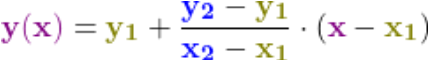

In [23]:
def interpolate_arrays(array1, array2, height1, height2, target_height):

    # Calculate the interpolation factor
    factor = (target_height - height1) / (height2 - height1) #factor = (x-x1)/(x2-x1)
    # Perform the interpolation
    interpolated_array = array1 + factor * (array2 - array1) #formular: y1 + factor *(y2 - y1)

    return interpolated_array

ws6_150m = interpolate_arrays(filtered_buoy6['wind_speed_140m'], filtered_buoy6['wind_speed_200m'], 140, 200, 150)
wd6_150m = interpolate_arrays(filtered_buoy6['wind_direction_140m'], filtered_buoy6['wind_direction_200m'], 140, 200, 150)
ws2_150m = interpolate_arrays(filtered_buoy2['wind_speed_140m'], filtered_buoy2['wind_speed_200m'], 140, 200, 150)
wd2_150m = interpolate_arrays(filtered_buoy2['wind_direction_140m'], filtered_buoy2['wind_direction_200m'], 140, 200, 150)

#test if they have the same shape 
print(ws6_150m.shape)
print(wd6_150m.shape)
print()
print(ws2_150m.shape)
print(wd2_150m.shape)



(52704,)
(52704,)

(52704,)
(52704,)


### 7. Compare Buoy 2 and Bouy 6 
- R2=1: This indicates a perfect fit, meaning that the regression line explains 100% of the variance in the dependent variable.
- 0.9≤R^2<1: Indicates an excellent fit, suggesting that the model explains a very high proportion of the variance.
- 0.7≤R^2<0.9: Indicates a good fit, suggesting that the model explains a substantial proportion of the variance.
- 0.5≤R^2<0.7: Indicates a moderate fit, meaning the model explains a reasonable amount of the variance, but there is still significant unexplained variance.
- R^2<0.5: Indicates a poor fit, suggesting that the model does not explain much of the variance in the dependent variable.

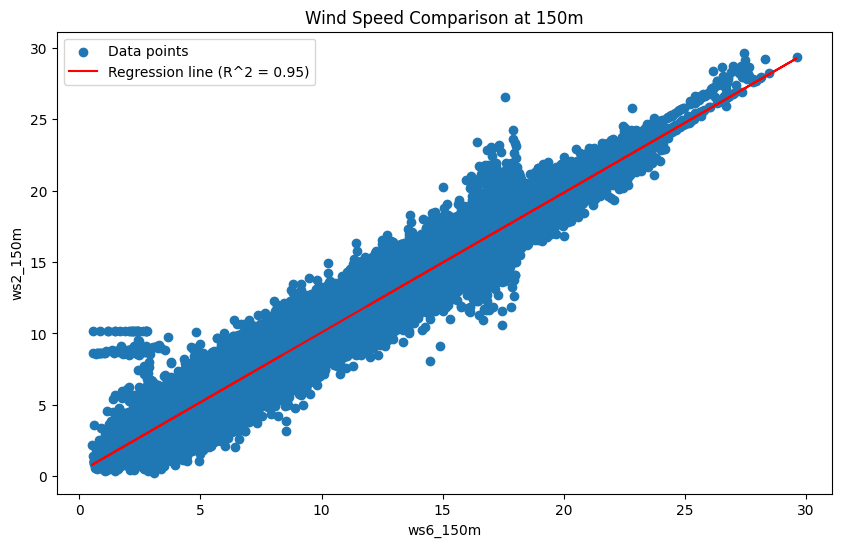

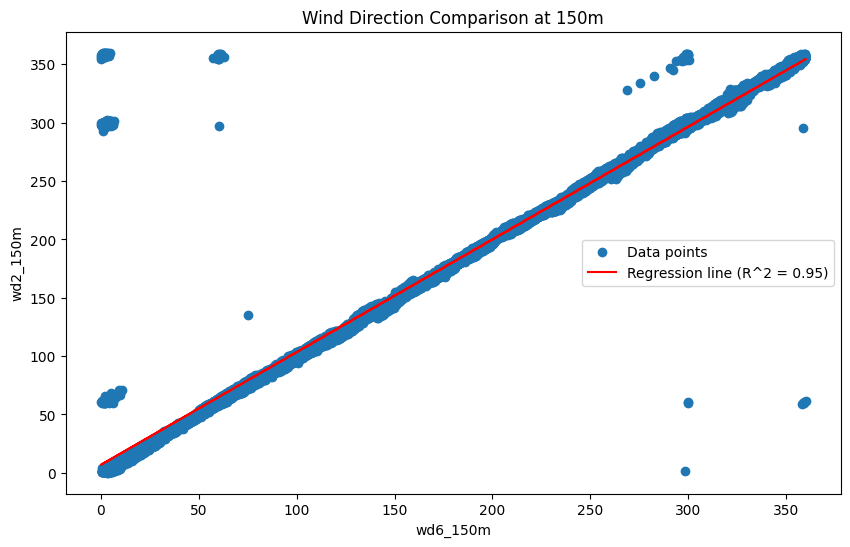

In [26]:
def plot_scatter_with_regression(x, y, xlabel, ylabel, title):
    # Perform linear regression
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # Create scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, label='Data points') #s=1 change scatter point size 

    # Plot regression line
    plt.plot(x, slope * x + intercept, color='red', label=f'Regression line (R^2 = {r_value**2:.2f})')

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

# Scatter plot for wind speed
plot_scatter_with_regression(ws6_150m, ws2_150m, 'ws6_150m', 'ws2_150m', 'Wind Speed Comparison at 150m') #52704 intervall points for one year 

# Scatter plot for wind direction
plot_scatter_with_regression(wd6_150m, wd2_150m, 'wd6_150m', 'wd2_150m', 'Wind Direction Comparison at 150m')


#### Plot the Timeseries for Buoy 2 and 6 

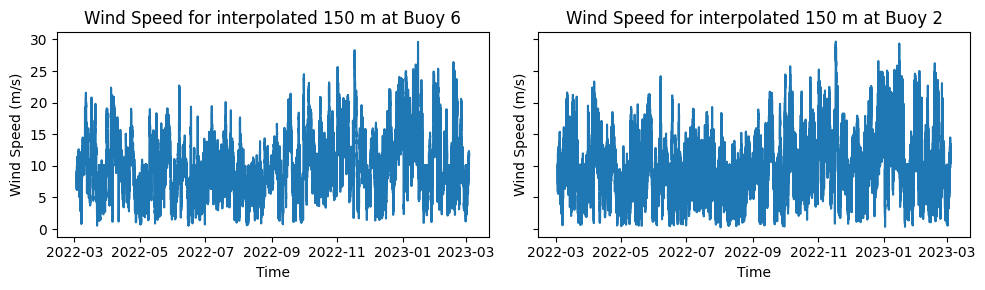

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True, sharex=True)

axes[0].plot(filtered_buoy6.index, ws6_150m)
axes[0].set_title('Wind Speed for interpolated 150 m at Buoy 6')
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Wind Speed (m/s)')

axes[1].plot(filtered_buoy2.index, ws2_150m)
axes[1].set_title('Wind Speed for interpolated 150 m at Buoy 2')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Wind Speed (m/s)')


# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

### 8. Short Term Wind Analysis for the interpolated 150m height


In [36]:
#mean, stdv, of annual ws 
mean_ws6 = np.mean(ws6_150m)
stdv_ws6 = np.std(ws6_150m)

mean_ws2 = np.mean(ws2_150m)
stdv_ws2 = np.std(ws2_150m)

print(f'Yearly Mean of ws Bouy_6: {mean_ws6:.2f}, Standard Deviation Buoy 6: {stdv_ws6:.2f}')
print(f'Yearly Mean of ws Bouy_2: {mean_ws2:.2f}, Standard Deviation Buoy 6: {stdv_ws2:.2f}')

#mean, stdv, of monthly ws 

def divide_into_bins_and_calculate_statistics(data, num_bins):
    # Calculate the size of each bin
    bin_size = len(data) // num_bins
    
    # Initialize lists to store the means and standard deviations of each bin
    bin_means = []
    bin_stds = []
    
    # Iterate through each bin
    for i in range(num_bins):
        # Determine the start and end indices of the bin
        start_idx = i * bin_size
        end_idx = start_idx + bin_size
        
        # Extract the bin data
        bin_data = data[start_idx:end_idx]
        
        # Calculate the mean of the bin
        bin_mean = np.mean(bin_data)
        
        # Calculate the standard deviation of the bin
        bin_std = np.std(bin_data)
        
        # Append the mean and standard deviation to their respective lists
        bin_means.append(bin_mean)
        bin_stds.append(bin_std)
    
    return bin_means, bin_stds


monthly_means_ws6, monthly_stds_ws6 = divide_into_bins_and_calculate_statistics(ws6_150m[:52704], 12)
monthly_means_ws2, monthly_stds_ws2 = divide_into_bins_and_calculate_statistics(ws2_150m[:52704], 12)


# Print the results with formatting
print("Monthly Means for Buoy 6:")
print([f"{mean:.2f}" for mean in monthly_means_ws6])

print("Monthly Standard Deviations for Buoy 6:")
print([f"{std:.2f}" for std in monthly_stds_ws6])


print("Monthly Means for Buoy 2:")
print([f"{mean:.2f}" for mean in monthly_means_ws2])

print("Monthly Standard Deviations for Buoy 2:")
print([f"{std:.2f}" for std in monthly_stds_ws2])


Yearly Mean of ws Bouy_6: 9.97, Standard Deviation Buoy 6: 4.79
Yearly Mean of ws Bouy_2: 10.04, Standard Deviation Buoy 6: 4.81
Monthly Means for Buoy 6:
['9.21', '9.46', '8.90', '8.20', '8.96', '6.99', '9.52', '11.27', '12.13', '11.91', '13.01', '10.05']
Monthly Standard Deviations for Buoy 6:
['4.39', '4.52', '4.16', '3.69', '3.25', '3.01', '4.68', '4.15', '4.96', '5.04', '5.83', '5.26']
Monthly Means for Buoy 2:
['9.24', '9.53', '9.05', '8.34', '9.05', '7.19', '9.70', '11.28', '12.11', '11.91', '12.99', '10.10']
Monthly Standard Deviations for Buoy 2:
['4.35', '4.49', '4.22', '3.77', '3.33', '3.10', '4.76', '4.21', '5.11', '5.02', '5.83', '5.30']


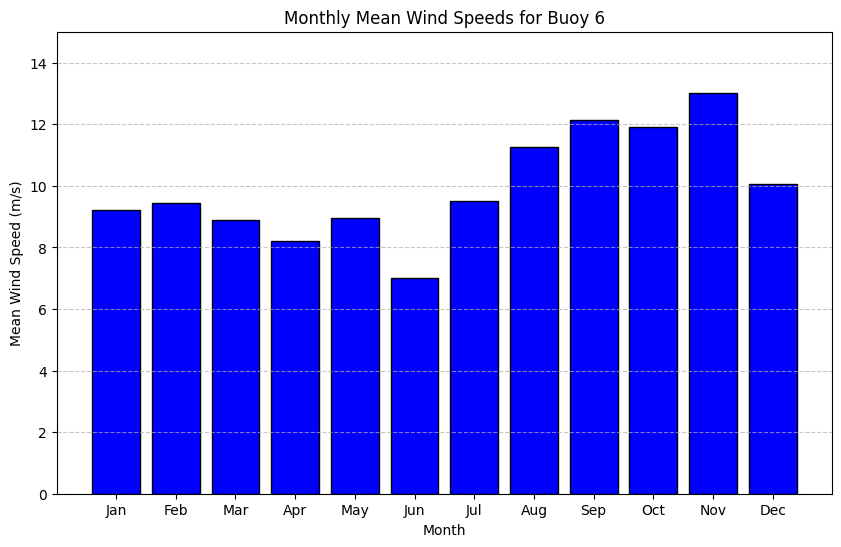

In [37]:
#plot bouy 6 monthly means 
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Plot the monthly mean wind speeds
plt.figure(figsize=(10, 6))
plt.bar(months, monthly_means_ws6, color='blue', edgecolor='black')
plt.title('Monthly Mean Wind Speeds for Buoy 6')
plt.xlabel('Month')
plt.ylabel('Mean Wind Speed (m/s)')
plt.ylim(0, max(monthly_means_ws6) + 2)  # Adjust y-axis limit for better visualization
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

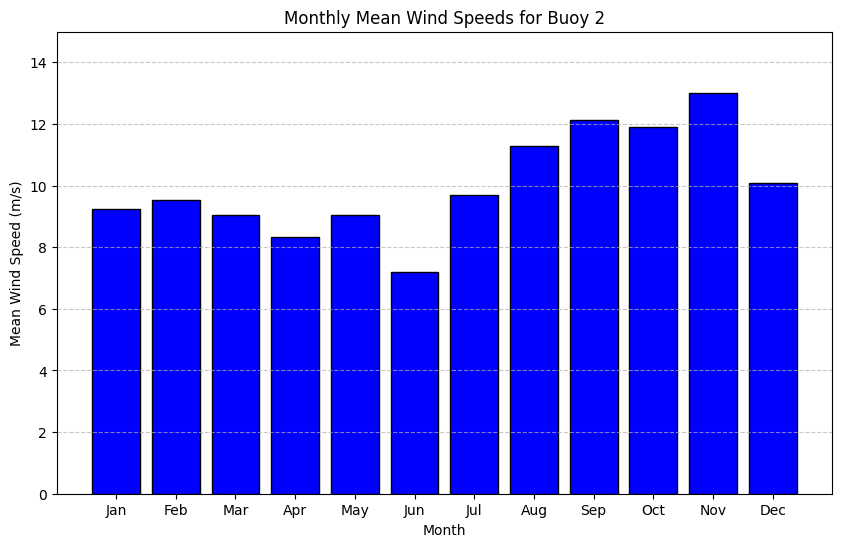

In [29]:
#plot bouy 6 monthly means 
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Plot the monthly mean wind speeds
plt.figure(figsize=(10, 6))
plt.bar(months, monthly_means_ws2, color='blue', edgecolor='black')
plt.title('Monthly Mean Wind Speeds for Buoy 2')
plt.xlabel('Month')
plt.ylabel('Mean Wind Speed (m/s)')
plt.ylim(0, max(monthly_means_ws2) + 2)  # Adjust y-axis limit for better visualization
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()